In [1]:
from pyhive.hive import connect
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
%matplotlib inline

ModuleNotFoundError: No module named 'pyhive'

In [2]:
# 将数据库中的表格导入开发环境中
keytab_file='gaohaojie@cnpc.com.cn.keytab'
user='gaohaojie'
host='11.11.206.232'
port=10000
active_str='kinit -kt {0} {1}'.format(keytab_file,user)
os.system(active_str)
con=connect(host=host,port=port,database='dw04_sjfx',auth='KERBEROS',kerberos_service_name="hive")
cursor=con.cursor()
dim_sql = "select * from app_gsms_kjyxxb_2020_carcard"
cursor.execute(dim_sql)
curinfo = cursor.fetchall()

In [3]:
# 设置列的最大打印量为无上限
pd.set_option('display.max_columns', None)

In [4]:
# 将导入的数组转换为数据表并进行表头重命名
df = pd.DataFrame(curinfo)
df.rename(columns = 
    {
    0:'帐号'
    1:'卡号',     
    2:'平均油量升数', 
    3:'平均实际金额', 
    4:'平均折扣金额', 
    5:'平均余额', 
    6:'类型名称', 
    7:'交易类型描述', 
    8:'商品类型', 
    9:'商品种类名称', 
    10:'单位名称', 
    11:'首次交易日期', 
    12:'最近交易日期',
    13:'是否睡眠卡',
    14:'IC卡大额非油消费次数',
    15:'车队卡非油累计消费金额是否过高', 
    16:'车队卡非油累计消费次数是否过多', 
    17:'车队卡累计消费次数', 
    18:'车队卡累计消费金额', 
    19:'单日高频充值次数', 
    20:'车队卡汽油消费次数占比', 
    21:'车队卡柴油消费次数占比',
    22:'车队卡天然气消费次数占比', 
    23:'单日高频消费次数', 
    24:'车队卡汽油累计消费次数', 
    25:'车队卡汽油累计消费金额', 
    26:'单日夜间高频消费次数', 
    27:'加油卡非油累计消费金额', 
    28:'加油卡非油消费占总消费占比',
    29:'车队卡柴油是否高额消费'
    }, 
        inplace=True)

### 频率工程

In [ ]:
# 去除不必要的字段
df_copy = df
df_copy = df_copy1.drop(['帐号', '首次交易日期', '最近交易日期'], axis=1)

In [ ]:
for i in ['类型名称', '交易类型描述', '商品类型', '商品种类名称', '单位名称']:
    column_dict = dict(df_copy[i].value_counts())
    df[i] = df.apply(lambda x: column_dict[x[i]]/df.shape[0], axis = 1)

### 特征缩放

In [9]:
# 将取值范围为0到1的字段*100
for i in ['类型名称', '交易类型描述', '商品类型', '商品种类名称', '单位名称', '车队卡非油累计消费金额是否过高', 
          '车队卡非油累计消费次数是否过多','加油卡非油消费占总消费占比', '车队卡柴油是否高额消费', '是否睡眠卡']:
    df_copy[i] = df_copy[i] * 100

In [10]:
# 将量级较大的字段归一化至范围为0到100
df_copy1 = df
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
x_minmax = min_max_scaler.fit_transform(df_copy1[['平均油量升数', '平均实际金额', '平均折扣金额', '平均余额', '车队卡累计消费金额',
                                                  '车队卡汽油累计消费金额','加油卡非油累计消费金额','IC卡大额非油消费次数',
                                                  '车队卡累计消费次数', '单日高频充值次数','单日高频消费次数', 
                                                  '车队卡汽油累计消费次数','单日夜间高频消费次数']])
df_minmax = pd.DataFrame(x_minmax)
df_minmax = df_minmax.rename(columns={0:'平均油量升数', 1:'平均实际金额', 2:'平均折扣金额', 3:'平均余额', 4:'车队卡累计消费金额', 
                                      5:'车队卡汽油累计消费金额', 6:'加油卡非油累计消费金额',7:'IC卡大额非油消费次数', 
                                      8:'车队卡累计消费次数', 9:'单日高频充值次数', 10:'单日高频消费次数', 
                                      11:'车队卡汽油累计消费次数',12:'单日夜间高频消费次数'})
df_minmax_concat1 = pd.concat([df_copy1.reset_index()['卡号'], df_minmax], axis = 1)
df_minmax_concat2 = pd.merge(df_minmax_concat1, df_copy.drop(['平均油量升数', '平均实际金额', '平均折扣金额', '平均余额', '车队卡累计消费金额',
                                                  '车队卡汽油累计消费金额','加油卡非油累计消费金额','IC卡大额非油消费次数',
                                                  '车队卡累计消费次数', '单日高频充值次数','单日高频消费次数', 
                                                  '车队卡汽油累计消费次数','单日夜间高频消费次数'], axis=1), on='卡号')
df_minmax_concat2 = df_minmax_concat2.set_index('卡号')

,油量升数,实际金额,折扣金额,余额,车队卡累计消费金额,汽油累计消费金额,加油卡非油累计消费金额,IC卡大额非油消费次数,车队卡累计消费笔数,单日高频充值次数,单日高频消费次数,汽油累计消费次数,单日夜间高频消费次数,类型名称,交易类型描述,商品类型,商品种类名称,单位名称,非油累计消费金额是否过高,非油累计消费次数是否过多,汽油消费占比,柴油消费占比,天然气消费占比,加油卡非油消费占比,车队卡柴油是否高额消费,是否睡眠卡
卡号,,,,,,,,,,,,,,,,,,,,,,,,,,
9100000001004465,0.310483,0.503650,0.0,0.039344,0.070847,0.112096,0.000000,0.0,0.068143,0.000000,0.000000,0.092836,0.0,24.158217,83.219223,38.213676,38.211320,1.514248,0,0,1.000000,0.000000,0.0,0.000000,0,0
9100000001041818,0.457178,0.753914,0.0,0.021135,0.086976,0.137615,0.000000,0.0,0.058106,0.000000,0.000000,0.079163,0.0,24.158217,83.219223,38.213676,38.211320,5.365035,0,0,1.000000,0.000000,0.0,0.000000,0,0
9100000001044671,0.342737,0.549980,0.0,0.000000,0.004690,0.007420,0.000000,0.0,0.004226,0.000000,0.000000,0.005757,0.0,24.158217,83.219223,38.213676,38.211320,5.365035,0,0,1.000000,0.000000,0.0,0.000000,0,0
9100000001049135,0.310358,0.499580,0.0,0.002985,0.008446,0.013364,0.000000,0.0,0.008452,0.280112,0.000000,0.011515,0.0,24.158217,83.219223,38.213676,38.211320,5.365035,0,0,1.000000,0.000000,0.0,0.000000,0,0
9100000001060538,0.447854,0.756876,0.0,0.049985,0.072481,0.020742,0.003469,0.0,0.055993,0.000000,2.185792,0.017272,0.0,24.158217,83.219223,12.889880,12.889117,1.066286,0,100,0.292683,0.707317,0.0,0.710100,0,0


#### 主成分分析技术（PCA）

In [14]:
# 创建一个PCA模型并适配数据表
pca = PCA(n_components = 5)
X2D = pca.fit_transform(df_minmax_concat2)

In [15]:
# 评估PCA降维后变量能够代表原数据变量的程度
print(pca.explained_variance_ratio_)

[0.38495252 0.1796159  0.15772253 0.14156461 0.09427755]


Text(0, 0.5, 'pc2')

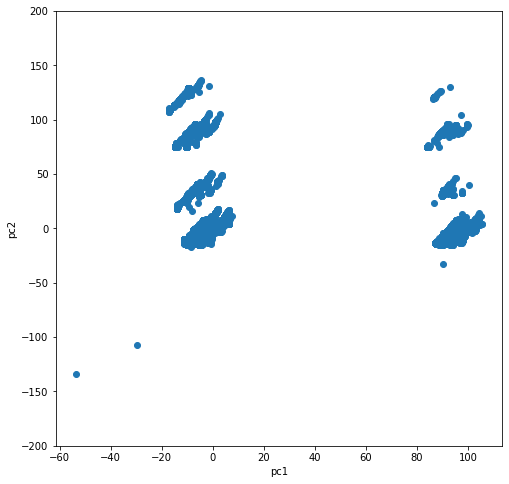

In [16]:
# 使用降维后变量绘制散点图观察趋势
plt.figure(figsize=(8,8))
plt.scatter(X2D[:,0],X2D[:,1])
plt.xlabel('pc1')
plt.ylabel('pc2')

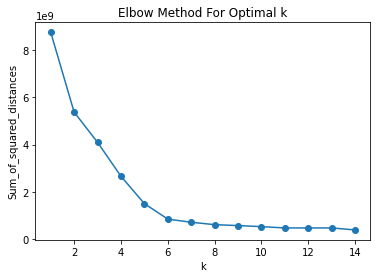

In [17]:
# # 使用肘部法则得出最佳的簇类数量
# Sum_of_squared_distances = []

# # Use k from 1 to 15
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=500,  tol=1e-04, random_state=0)
#     km = km.fit(X2D)
#     # Get sum of square distances by applying km.inertia_ 
#     Sum_of_squared_distances.append(km.inertia_)

# # Plot Results
# plt.plot(K, Sum_of_squared_distances, marker='o')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

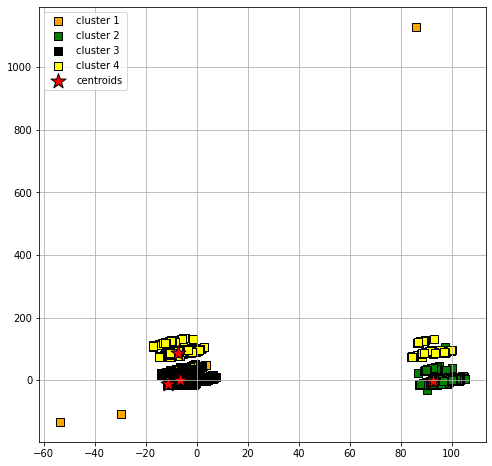

In [18]:
# # 使用KMeans进行数据标签分类 (两类)
# # 每个循环跑10次，共跑500个循环

# cluster_num = 4

# km = KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, max_iter=500,  tol=1e-04, random_state=0)
# y_km = km.fit_predict(X2D)
# plt.figure(figsize=(8,8))

# # 使用散点图画出两类数据标签及分布中心
# colors = ["orange", "green", 'black', 'yellow', 'blue', 'brown']
# for i in range(cluster_num):
#     plt.scatter(X2D[y_km == i, 0], X2D[y_km == i, 1], s=50, c=colors[i], 
#                 marker = 's', edgecolor="black", label="cluster %d"%(i+1))

# plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
#             s=250, marker='*',c='red', edgecolor='black',label='centroids')
# plt.legend(scatterpoints=1)
# plt.grid()

#### 返回原数据表（Kmeans++）

In [19]:
X2D_df = pd.DataFrame(X2D)
r = pd.concat([X2D_df, pd.Series(train_km.labels_, index = X2D_df.index)], axis = 1)  #每个样本对应的类别
r.columns = list(X2D_df.columns) + [u'聚类类别'] #重命名表头

In [20]:
# 计算每个数据点距离簇类中心的相对距离
distance = pd.DataFrame()
for i in range(cluster_num): 
    distance_ind = pd.DataFrame()
    distance_ind = r[[0,1]][r[u'聚类类别'] == i] - km.cluster_centers_[i, 0:2]
    distance_ind['absolute distance'] = (distance_ind[0] ** 2 + distance_ind[1] ** 2) ** 0.5
    distance = distance.append(distance_ind)
r['absolute distance'] = distance['absolute distance']

r.drop(['聚类类别'], axis=1)

In [21]:
# 将异常点和正常点画出来
threshold = 5
normal = r[r['absolute distance'] <= threshold]
normal = normal.drop(['absolute distance'], axis = 1)

plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.figure(figsize=(10,9))

plt.scatter(normal[0], normal[1], marker='o')

discrete_points = r[r['absolute distance'] > threshold] #离群点

plt.scatter(discrete_points[0], discrete_points[1], marker='x')

plt.xlabel('pca1')
plt.ylabel('pca2')
plt.show()

In [23]:
# 打印映射的原数据表内容
abnormal = df.iloc[list(discrete_points.index)]

In [24]:
以csv格式导出
abnormal.to_csv('车队卡全量异常.csv')

#### 孤立森林算法

In [26]:
# Grid Search调参，打印最佳参数

from sklearn.model_selection import GridSearchCV
X2D = pd.DataFrame(X2D)
X2D.shape[0]

# Grid Search
tuned = {'n_estimators':[100, 200, 300], 'max_samples':[1000, 3000, 5000]}

def scorer_f(estimator, X):   #your own scorer
      return np.mean(estimator.score_samples(X))

isolation_forest = GridSearchCV(IsolationForest(), tuned, scoring=scorer_f)
model = isolation_forest.fit(X2D)

model.best_params_

{'max_samples': 5000, 'n_estimators': 200}

In [ ]:
# 创建模型
ilf = IsolationForest(n_estimators = model.best_params_['n_estimators'],
                      max_samples = model.best_params_['max_samples'],
                      n_jobs= -1,          # 使用全部cpu
                      contamination = 0.001,
                      verbose= 1
    )

# 模型训练
Iso_model = ilf.fit(X2D[[0,1,2,3,4]])

(4608078, 5)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   17.5s remaining:   52.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   18.3s finished


### 存储模型

In [ ]:
# 存储训练好的模型至开发环境中
joblib.dump(Iso_model, 'Iso.model')